In [34]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

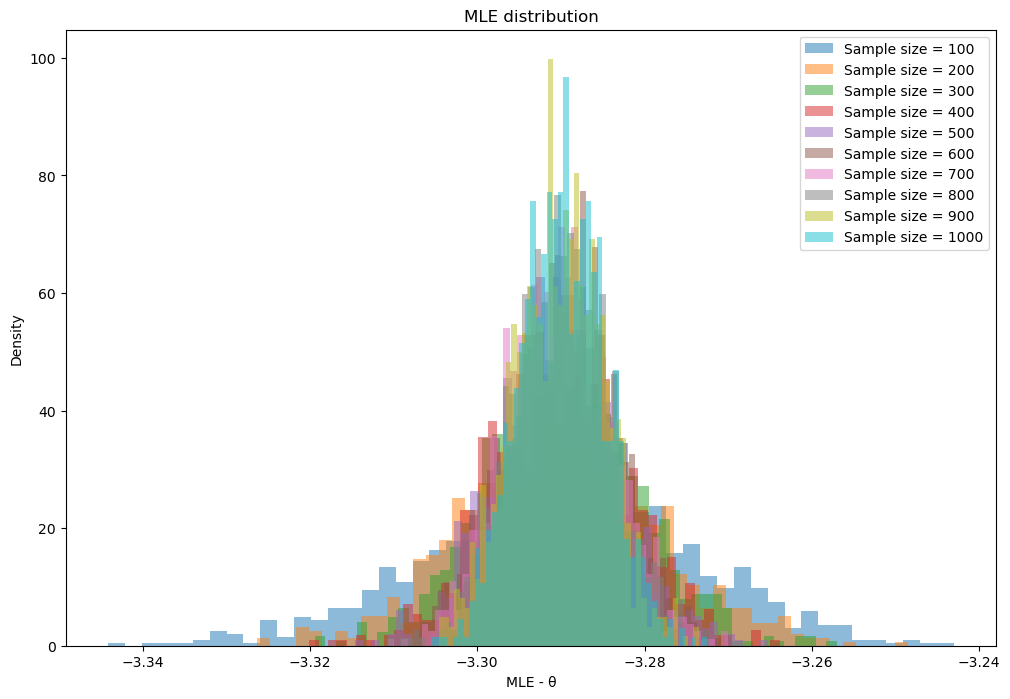

Bias: [-3.29031492 -3.28999381 -3.28980555 -3.29030033 -3.29045791 -3.28988696
 -3.29023481 -3.29014689 -3.29022456 -3.28978786]
Variance: [2.60503323e-04 1.34185062e-04 8.58772402e-05 6.59255823e-05
 4.98904544e-05 4.16935386e-05 3.95758610e-05 3.39771672e-05
 2.90137746e-05 2.52845902e-05]
MSE: [10.82643277 10.82419345 10.82290645 10.82614221 10.82716312 10.82339788
 10.82568469 10.82510055 10.82560667 10.82272944]
Out of threshold: [270. 201. 128. 107.  96.  65.  58.  42.  37.  17.]


In [35]:

def f_theta(x, theta):
    return (3 * x**2 / np.sqrt(2 * np.pi)) * np.exp(-((theta - x**3)**2) / 2)

def log_likelihood(x, theta):
    return np.sum(np.log(f_theta(x, theta)))


# дифф по тете и получил вот ето
def mle(x):
    return np.cbrt(np.mean(x**3))


theta = 5
n_list = [i * 100 for i in range(1,11)]
m = 1000
threshold = 3.3

# Задает массивы для хранения результатов.
mle_results = np.zeros((len(n_list), m))
bias_results = np.zeros(len(n_list))
variance_results = np.zeros(len(n_list))
mse_results = np.zeros(len(n_list))
out_of_threshold = np.zeros(len(n_list))

for i, n in enumerate(n_list):
    for j in range(m):

        u = np.random.uniform(0, 1, n)
        x = np.cbrt(np.sqrt(2) * stats.norm.ppf(u) + theta)


        mle_results[i, j] = mle(x)


    bias_results[i] = np.mean(mle_results[i, :]) - theta
    variance_results[i] = np.var(mle_results[i, :])
    mse_results[i] = np.mean((mle_results[i, :] - theta)**2)

    #проверка абсолютной ошибки
    out_of_threshold[i] = np.sum(np.abs(mle_results[i, :] - theta) > threshold)


plt.figure(figsize=(12, 8))
for i, n in enumerate(n_list):
    plt.hist((mle_results[i, :] - theta), bins=50, density=True, alpha=0.5, label=f"Sample size = {n}")
plt.legend()
plt.xlabel("MLE - θ")
plt.ylabel("Density")
plt.title("MLE distribution")
plt.show()

print("Bias:", bias_results)
print("Variance:", variance_results)
print("MSE:", mse_results)
print("Out of threshold:", out_of_threshold)
